In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

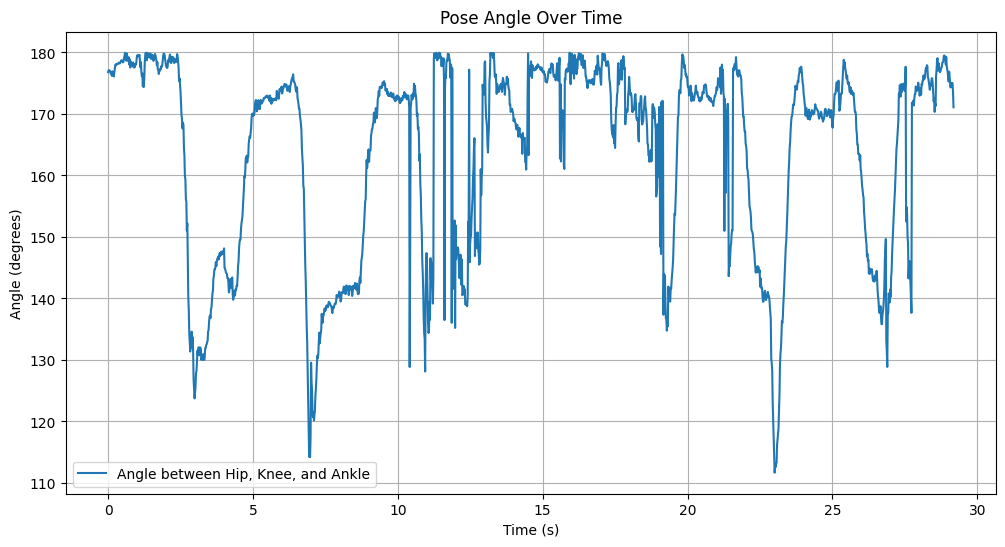

In [4]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']   # importing

EDGES = {
    (0, 1): 'm', (0, 2): 'c', (1, 3): 'm', (2, 4): 'c',
    (0, 5): 'm', (0, 6): 'c', (5, 7): 'm', (7, 9): 'm',
    (6, 8): 'c', (8, 10): 'c', (5, 6): 'y', (5, 11): 'm',   # used for the colour ;
    (6, 12): 'c', (11, 12): 'y', (11, 13): 'm', (13, 15): 'm',
    (12, 14): 'c', (14, 16): 'c'
}

def calculate_angle(a, b, c):  # angel calculation
    ab = np.array(a) - np.array(b)
    bc = np.array(c) - np.array(b)
    cos_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    return angle

def draw_keypoints(frame, keypoints, confidence_threshold):  # keypoints marking
    y, x, c = frame.shape  # get hieght and width
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))

    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0, 255, 0), -1)

def draw_connections(frame, keypoints, edges, confidence_threshold): # draw the connections
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))

    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]

        if (c1 > confidence_threshold) & (c2 > confidence_threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 4)

def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold): # to find the pose fro multiple persons
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)


def process_video(video_path): # processing the video
    cap = cv2.VideoCapture(video_path)
    angles = []
    frame_times = []

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter('Multi_pose.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        img = frame.copy()
        img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384, 640)
        input_img = tf.cast(img, dtype=tf.int32)

        results = movenet(input_img)
        keypoints_with_scores = results['output_0'].numpy()[:, :, :51].reshape((6, 17, 3))

        person = keypoints_with_scores[0]
        left_hip = person[11][:2]
        left_knee = person[13][:2]
        left_ankle = person[15][:2]

        angle = calculate_angle(left_hip, left_knee, left_ankle)
        angles.append(angle)
        frame_times.append(cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0)

        loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
        out.write(frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    files.download('Multi_pose.mp4')
    return frame_times, angles

def plot_angles(frame_times, angles):
    plt.figure(figsize=(12, 6))
    plt.plot(frame_times, angles, label='Angle between Hip, Knee, and Ankle')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degrees)')
    plt.title('Pose Angle Over Time')
    plt.legend()
    plt.grid()
    plt.show()

video_path = '/content/video.mp4'


frame_times, angles = process_video(video_path)
plot_angles(frame_times, angles)
